In [1]:
from HARK.distributions import Bernoulli, Lognormal, MeanOneLogNormal, Normal
from HARK.model import Control, DBlock, RBlock

from HARK.simulation.monte_carlo import MonteCarloSimulator

import math

In [25]:
calibration = {
    "DiscFac": 0.96,
    "CRRA": 2.0,
    "rho" : 0.95,
    "R": 1.03, # will get overridden
    "TranShkStd": 0.1,
    "debt_limit" : -1
}

In [26]:
consumption_block = DBlock(
    **{
        "name": "consumption",
        "shocks": {
            "theta": (Normal, {"mu" : 0, "sigma": "TranShkStd"}),
        },
        "dynamics": {
            "y": lambda y, rho, theta: y * rho + theta,
            "R" : Control(["a", "y"]),
            "w": lambda a, R, y: R * a + math.e ** y,
            "c": Control("w"), # constraint c < w - debt_limit
            "a": lambda w, c: w - c,
        },
        "reward": {
            "u": lambda c, CRRA: c ** (1 - CRRA) / (1 - CRRA),
            "d": lambda a, R: - a * R 
        },
    }
)

In [29]:
# In your notebook or main script
from model_visualizer import create_block_diagram


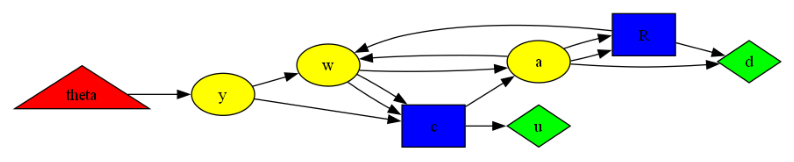

In [30]:
# For your consumption block
create_block_diagram(consumption_block)

In [4]:
import pydot
import math
import matplotlib.pyplot as plt
from IPython.display import display
from inspect import signature

In [5]:
# Define different colors & shapes for variable types
style_map = {
    "Control": {"shape": "rectangle", "color": "blue"},  # Control variables (decisions)
    "Reward": {"shape": "diamond", "color": "green"},   # Rewards
    "Shock": {"shape": "triangle", "color": "red"},    # Shocks (exogenous)
    "State": {"shape": "ellipse", "color": "yellow"}    # Default for state variables
}

# Create a directed graph
graph = pydot.Dot("ModelStructure", graph_type="digraph", rankdir="LR")

In [6]:
# Extract variables dynamically
for var_name, func in consumption_block.dynamics.items():
    var_type = "State"
    dependencies = []

    if isinstance(func, Control):
        var_type = "Control"
        # For Control variables, we need to determine dependencies
        # This gets parameters that the control decision depends on
        if var_name == "c":
            # Consumption typically depends on wealth in consumer models
            dependencies.append("w")
        elif var_name == "R":
            # Interest rate might depend on assets
            dependencies.append("a")
    else:
        # For non-Control variables, get all input parameters
        dependencies = list(signature(func).parameters.keys())
        
        # Special handling for AR processes (like income)
        if var_name == "y" and "y" in dependencies:
            # Create a clearer label for the self-reference to show time dependency
            # First remove the self-reference
            dependencies.remove("y")
            # Then add it with a time indicator
            dependencies.append("y")  # Will create the self-referential arrow
            # Note: In visualization, this represents y_t → y_{t+1}

    node_style = style_map[var_type]
    graph.add_node(
        pydot.Node(
            var_name,
            shape=node_style["shape"],
            fillcolor=node_style["color"],
            style="filled"
        )
    )
    
    for dep in dependencies:
        graph.add_edge(pydot.Edge(dep, var_name))

# Add Shock variables
for shock in consumption_block.shocks.keys():
    node_style = style_map["Shock"]
    
    graph.add_node(
        pydot.Node(
            shock,
            shape=node_style["shape"],
            fillcolor=node_style["color"],
            style="filled"
        )
    )

# Add Reward variables
for reward_name, reward_func in consumption_block.reward.items():
    node_style = style_map["Reward"]
    
    graph.add_node(
        pydot.Node(
            reward_name,
            shape=node_style["shape"],
            fillcolor=node_style["color"],
            style="filled"
        )
    )
    
    for arg in signature(reward_func).parameters:
        graph.add_edge(pydot.Edge(arg, reward_name))

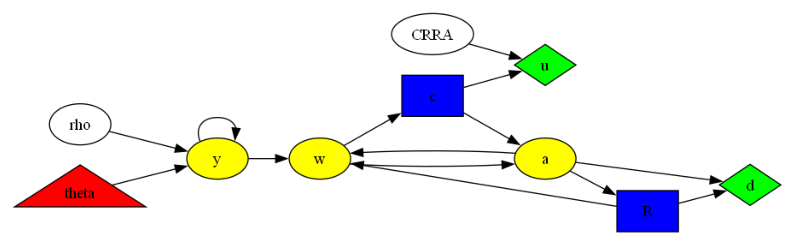

In [7]:
# Render graph and display it
graph.write_png("model_structure.png")

# Use matplotlib to display the image
img = plt.imread("model_structure.png")
plt.figure(figsize=(10, 7))
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

## How to set $R$

Let `R = Control(a, y)` be the rule for how money is lent.

This is a simple that avoids the state explosion of history.
But since `y` is autoregressive that's fine.

We can look at the dynamics with different rules.

### Todo: test with a couple variations of rules and plot the outcomes.

In [7]:
sim = MonteCarloSimulator(  ### Use fm, blockified
    calibration,
    consumption_block,
    {
        "R": lambda a, y : 1.03,
        "c": lambda w: w,
    },
    {  # initial states
        "a": 1,
        "y": 1.0,
    },
    agent_count=3,
    T_sim=120,
)

sim.initialize_sim()
hist = sim.simulate()

{'DiscFac': 0.96, 'CRRA': 2.0, 'rho': 0.95, 'R': array([nan, nan, nan]), 'TranShkStd': 0.1, 'debt_limit': -1, 'theta': array([ 0.01257302, -0.01321049,  0.06404227]), 'y': array([1., 1., 1.]), 'w': array([nan, nan, nan]), 'c': array([nan, nan, nan]), 'a': array([1., 1., 1.]), 'u': array([nan, nan, nan]), 'd': array([nan, nan, nan])}
{'DiscFac': 0.96, 'CRRA': 2.0, 'rho': 0.95, 'R': 1.03, 'TranShkStd': 0.1, 'debt_limit': -1, 'theta': array([ 0.01049001, -0.05356694,  0.03615951]), 'y': array([0.96257302, 0.93678951, 1.01404227]), 'w': array([3.64842508, 3.58177581, 3.78672192]), 'c': array([3.64842508, 3.58177581, 3.78672192]), 'a': array([0., 0., 0.]), 'u': array([-0.27409087, -0.27919112, -0.26408065]), 'd': array([-0., -0., -0.])}
{'DiscFac': 0.96, 'CRRA': 2.0, 'rho': 0.95, 'R': 1.03, 'TranShkStd': 0.1, 'debt_limit': -1, 'theta': array([ 0.1304    ,  0.0947081 , -0.07037352]), 'y': array([0.92493438, 0.8363831 , 0.99949966]), 'w': array([2.52170279, 2.30800404, 2.7169221 ]), 'c': arra

### Implement value backup on the two rewards, see if it reaches a steady state.

In [8]:
f = lambda a, b, c, d: a + b - c * d

In [11]:
args = {
    'a' : 1,
    'b': 2,
    'c' : 3,
    'd' : 4,
    'e' : 5
}

In [13]:
f(*args)

TypeError: <lambda>() takes 4 positional arguments but 5 were given